In [1]:
%pylab inline
import radvel
import pandas as pd
import os
from scipy import optimize
import corner
rc('savefig',dpi=120)

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 30 days
/Users/petigura/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Populating the interactive namespace from numpy and matplotlib


In [36]:
path = os.path.join(radvel.DATADIR,'epic203771098.hdf')
planet = pd.read_hdf(path,'planet')
rv = pd.read_hdf(path,'rv')

def initialize_model():
    time_base = 2420
    params = radvel.RVParameters(2,basis='per tc secosw sesinw k')
    params['per1'] = planet.ix['P','b']
    params['tc1'] = planet.ix['t0','b']
    params['secosw1'] = 0.01
    params['sesinw1'] = 0.01
    params['k1'] = 5.0
    params['per2'] = planet.ix['P','c']
    params['tc2'] = planet.ix['t0','c']
    params['secosw2'] = 0.01
    params['sesinw2'] = 0.01
    params['k2'] = 5.0
    params['dvdt'] = -0.02
    mod = radvel.RVModel(params, time_base=time_base)
    return mod


t = np.array(rv.t)
vel = np.array(rv.vel)
errvel = rv.errvel

ti = linspace(rv.t.iloc[0]-5,rv.t.iloc[-1]+5,100)

def plot_results(like):
    fig = gcf()
    errorbar(
        like.x, like.model(t)+like.residuals(), 
        yerr=like.yerr, fmt='o'
        )
    plot(ti, like.model(ti))
    fig.set_tight_layout(True)
    xlabel('Time')
    ylabel('RV')
    draw()

Fit EPIC-2307 light curve
=========================
1. circular orbits
2. fixed period, time of transit

   status: 0
  success: True
     nfev: 438
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      fun: 90.544842485164054
        x: array([ 4.86407687, -0.06805266,  4.35500894, -3.87216465,  1.18067453])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
      jac: array([-0.29201175, -0.49287792, -0.08346603,  0.25477789,  0.32824801])
      nit: 16
parameter                value       vary
dvdt                -0.0680527       True
gamma                 -3.87216       True
k1                     4.35501       True
k2                     4.86408       True
logjit                 1.18067       True
per1                   20.8851      False
per2                   42.3638      False
secosw1                   0.01      False
secosw2                   0.01      False
sesinw1                   0.01      False
sesinw2                   0.01      False
tc1                     2072.8      False
tc2                    2082.62      False
Priors
------
Gaussian Prior on logjit,

/Users/petigura/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:21: OptimizeWarning: Unknown solver options: epsilon


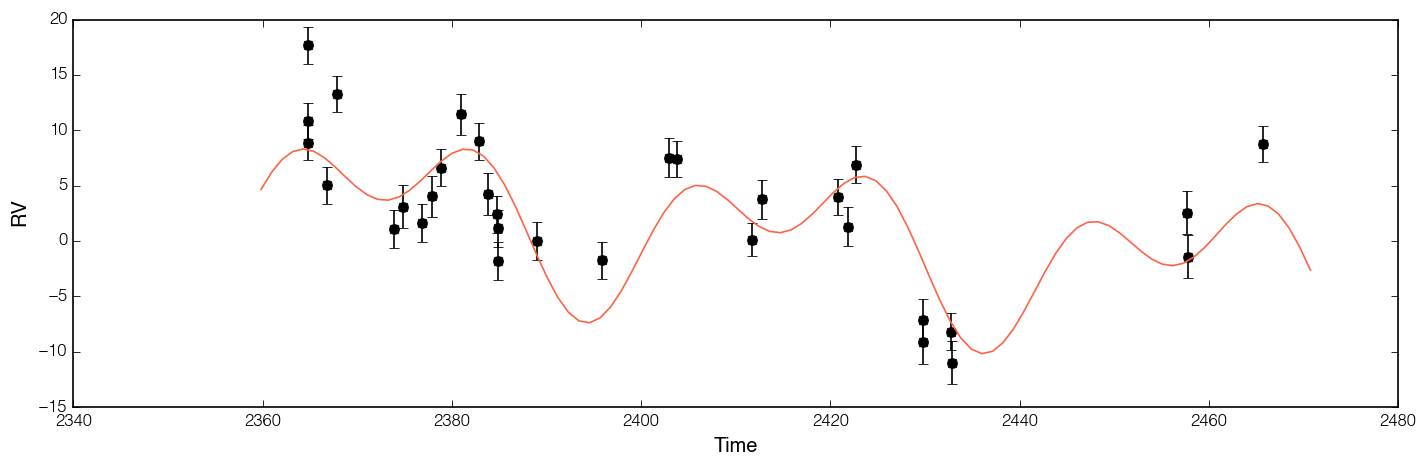

In [38]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, t, vel, errvel)

like.params['gamma'] = 0.0
like.params['logjit'] = np.log(1)
like.vary['secosw1'] = False
like.vary['sesinw1'] = False
like.vary['secosw2'] = False
like.vary['sesinw2'] = False
like.vary['per1'] = False
like.vary['per2'] = False
like.vary['tc1'] = False
like.vary['tc2'] = False

post = radvel.posterior.Posterior(like)
#post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(3), 0.5)]

#plot_results(like) # Plot initial model
#res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B' ,options=dict(epsilon=1e-4))
print res
#print like_syn
fig = figsize(12,4)
plot_results(like) # plot best fit model
print post

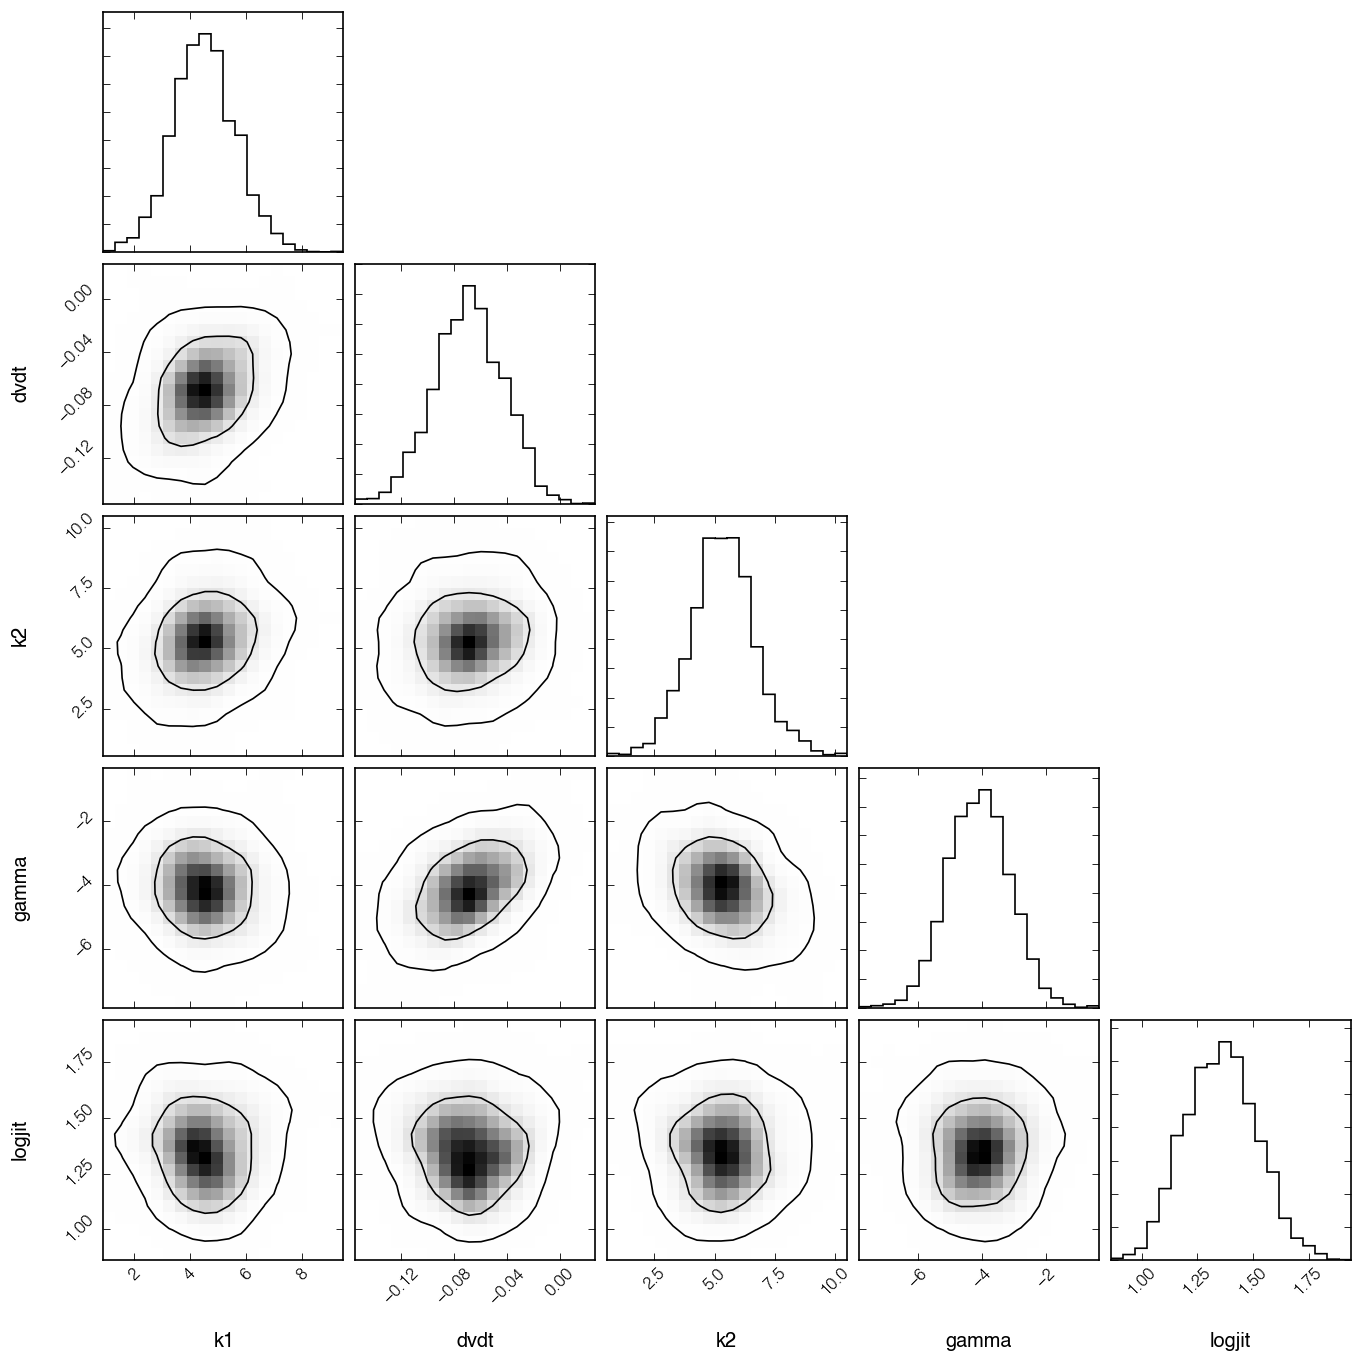

In [39]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=500)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

In [40]:
df.describe()

,k2,dvdt,k1,gamma,logjit,lnprobability
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.340921,-0.069095,4.510839,-4.098131,1.356900,-92.830293
std,1.355254,0.026330,1.117449,0.979499,0.159770,1.687902
min,0.534410,-0.154741,0.887240,-7.852689,0.861114,-102.789043
25%,4.484292,-0.086382,3.772000,-4.776685,1.244003,-93.721961
50%,5.312603,-0.068736,4.485369,-4.091456,1.357558,-92.438914
75%,6.162625,-0.050986,5.216552,-3.446322,1.464799,-91.577047
max,10.488211,0.026187,9.459334,-0.336231,1.940376,-90.217058


Fit EPIC-2307 light curve
=========================
1. eccentric orbits
2. fixed period, time of transit

  status: 0
    nfev: 1194
 success: True
     fun: 104.7804867692325
       x: array([-0.06098046,  0.02449138, -0.0050313 , -0.00808767, -0.00321181,
        1.70806453,  0.066236  ,  0.19870843,  1.75458185])
 message: 'Optimization terminated successfully.'
     nit: 823
parameter                value       vary
dvdt               -0.00808767       True
gamma              -0.00321181       True
logjit              -0.0050313       True
logk1                  1.75458       True
logk2                  1.70806       True
per1                   20.8851      False
per2                   42.3638      False
secosw1              0.0244914       True
secosw2             -0.0609805       True
sesinw1               0.066236       True
sesinw2               0.198708       True
tc1                     2072.8      False
tc2                    2082.62      False
Priors
------
Generic Prior
Gaussian Prior on logjit, mu=1.09861228867, sigma=0.5



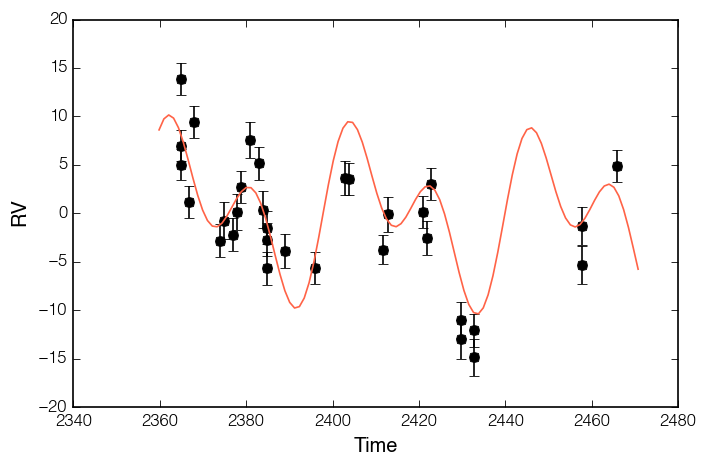

In [18]:
mod = initialize_model()
like = radvel.likelihood.RVLikelihood(mod, array(rv.t), array(rv.vel), array(rv.errvel))

like.params['gamma'] = 0.0
like.params['logjit'] = np.log(1)
like.vary.update(per1=False,per2=False,tc1=False,tc2=False)
like.params.update(secosw1=0.1,sesinw1=0.1,secosw2=0.1,sesinw2=0.1)

post = radvel.posterior.Posterior(like)
post.priors += [radvel.prior.EccentricityPrior( 2 )]
post.priors += [radvel.prior.Gaussian( 'logjit', log(3), 0.5)]

#plot_results(like) # Plot initial model
res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )
#res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='L-BFGS-B' )
print res
#print like_syn
plot_results(like) # plot best fit model
print post

In [19]:
%prun res  = optimize.minimize(post.neglogprob_array, post.get_vary_params(), method='Nelder-Mead' )

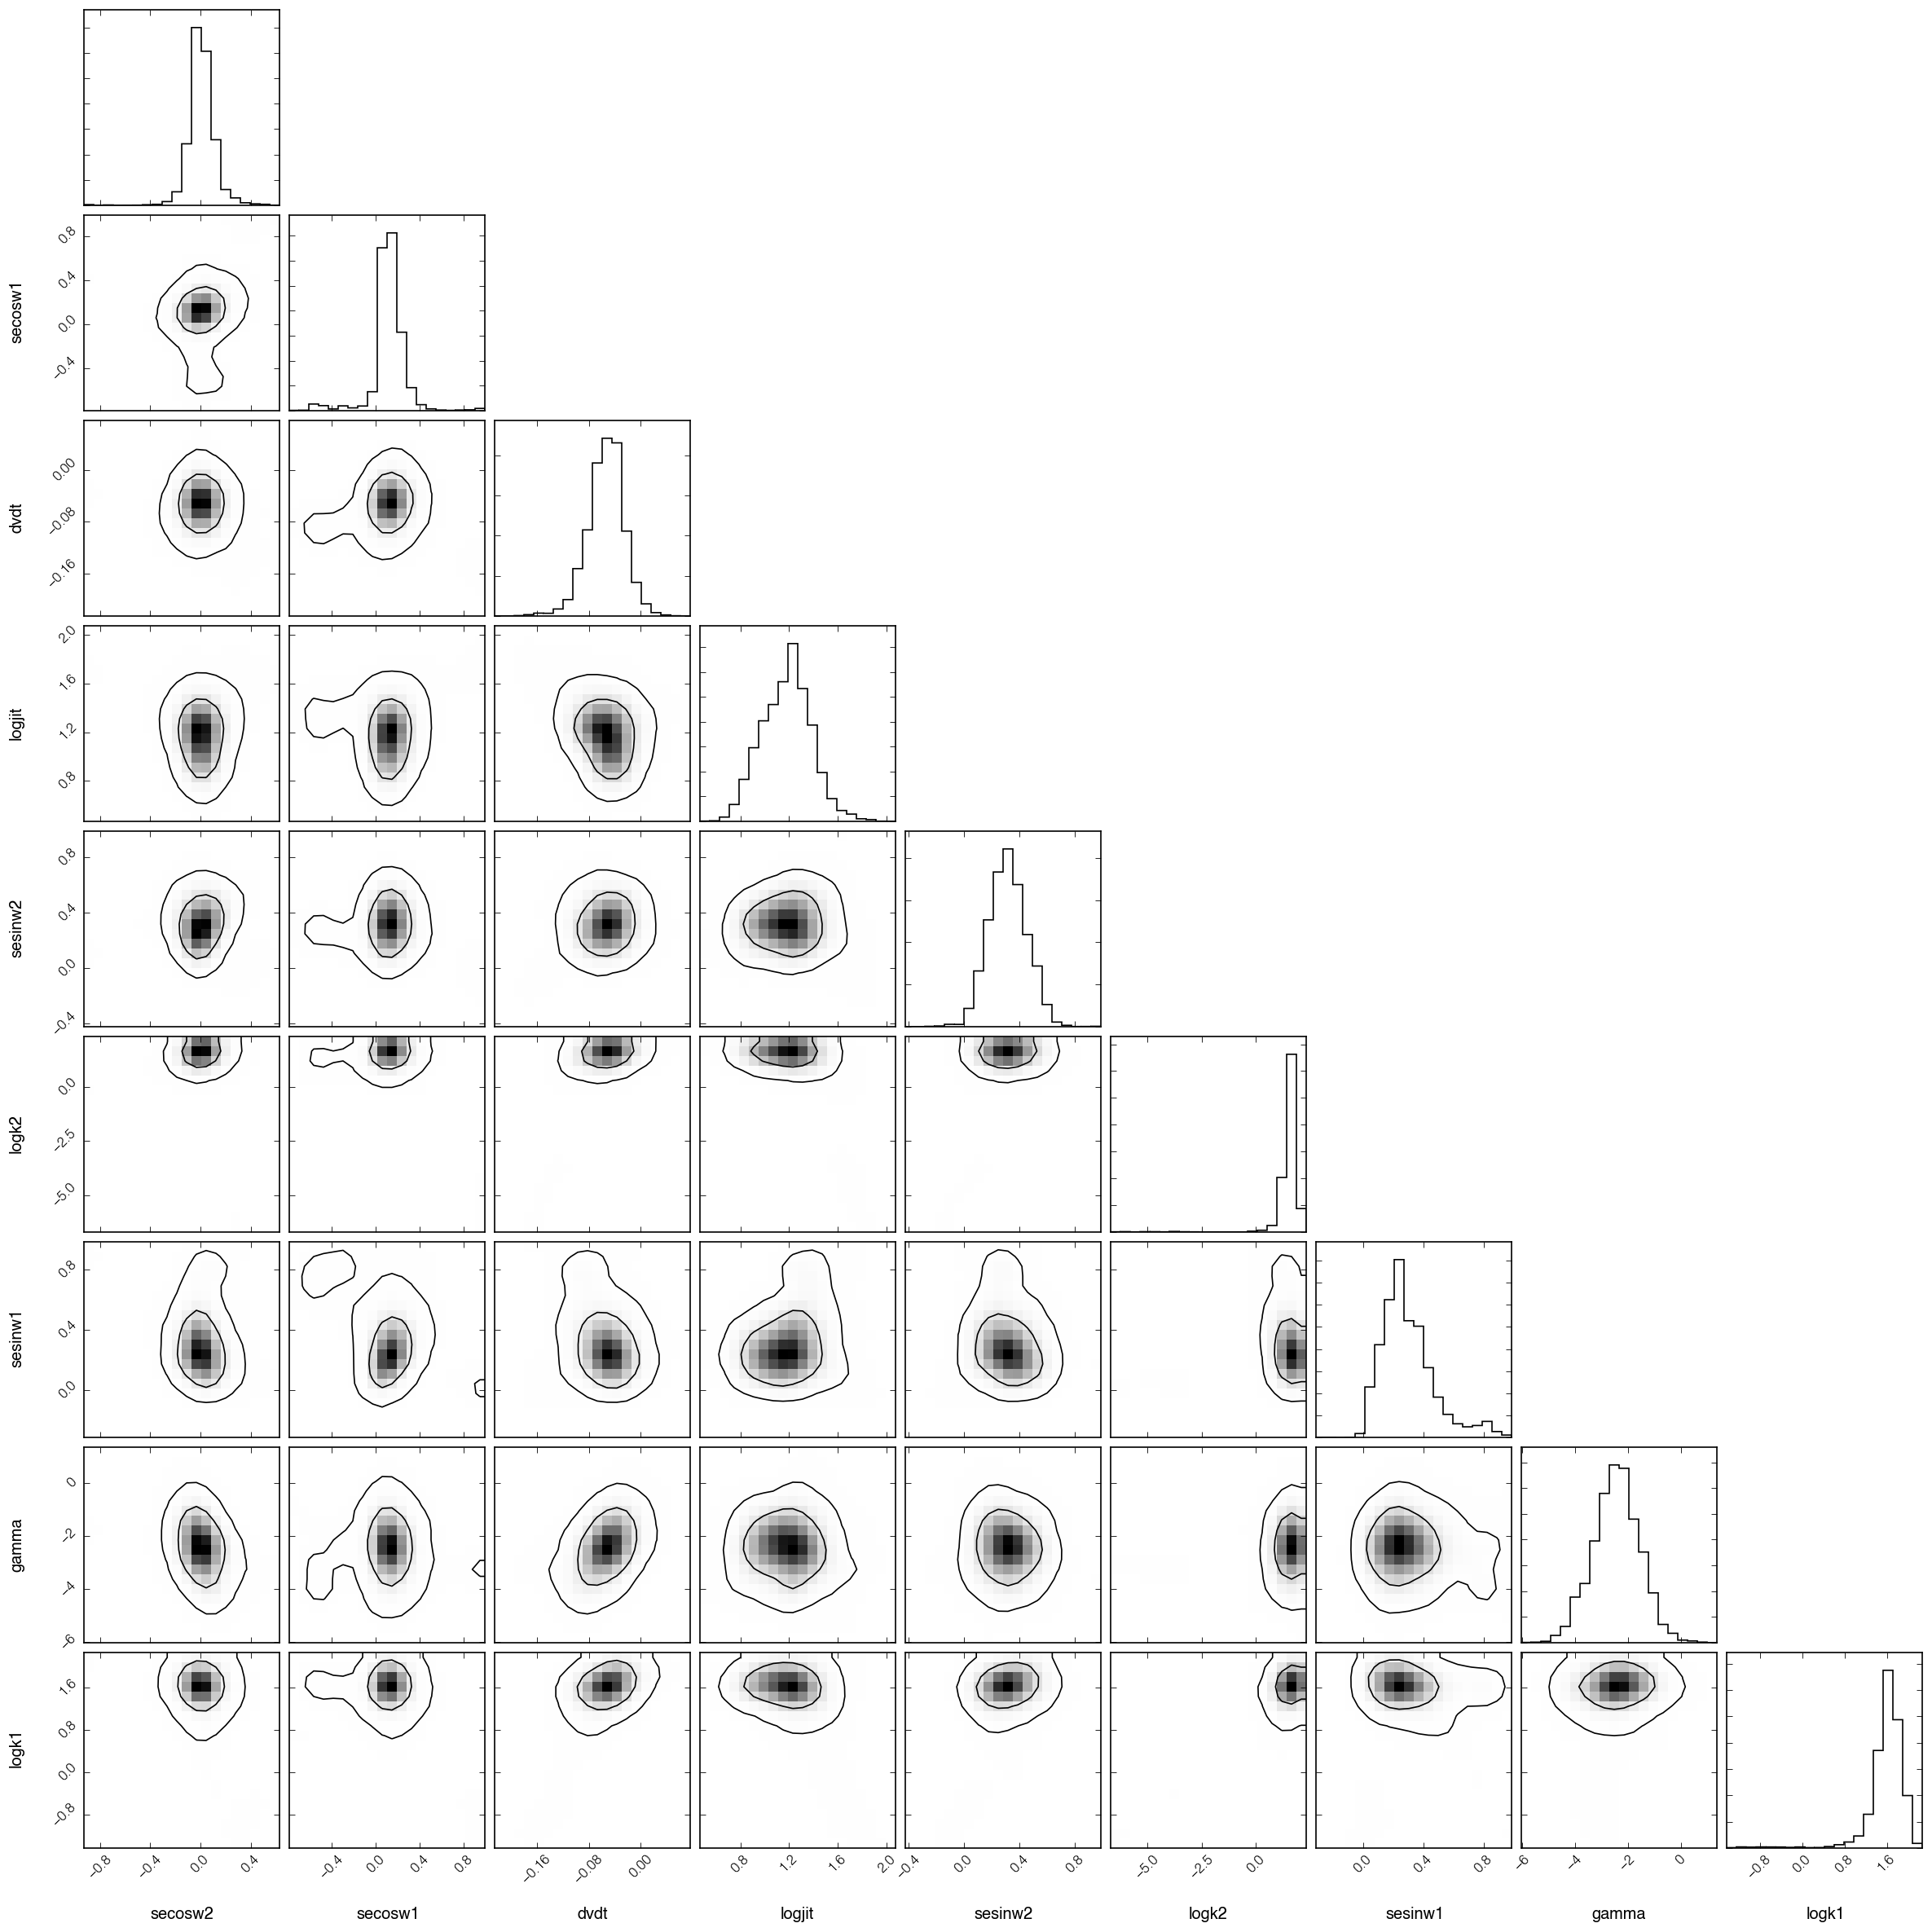

In [24]:
df = radvel.mcmc(post,threads=1,nburn=1000,nwalkers=20,nrun=1000)
labels = [k for k in post.vary.keys() if post.vary[k]]
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20
    )

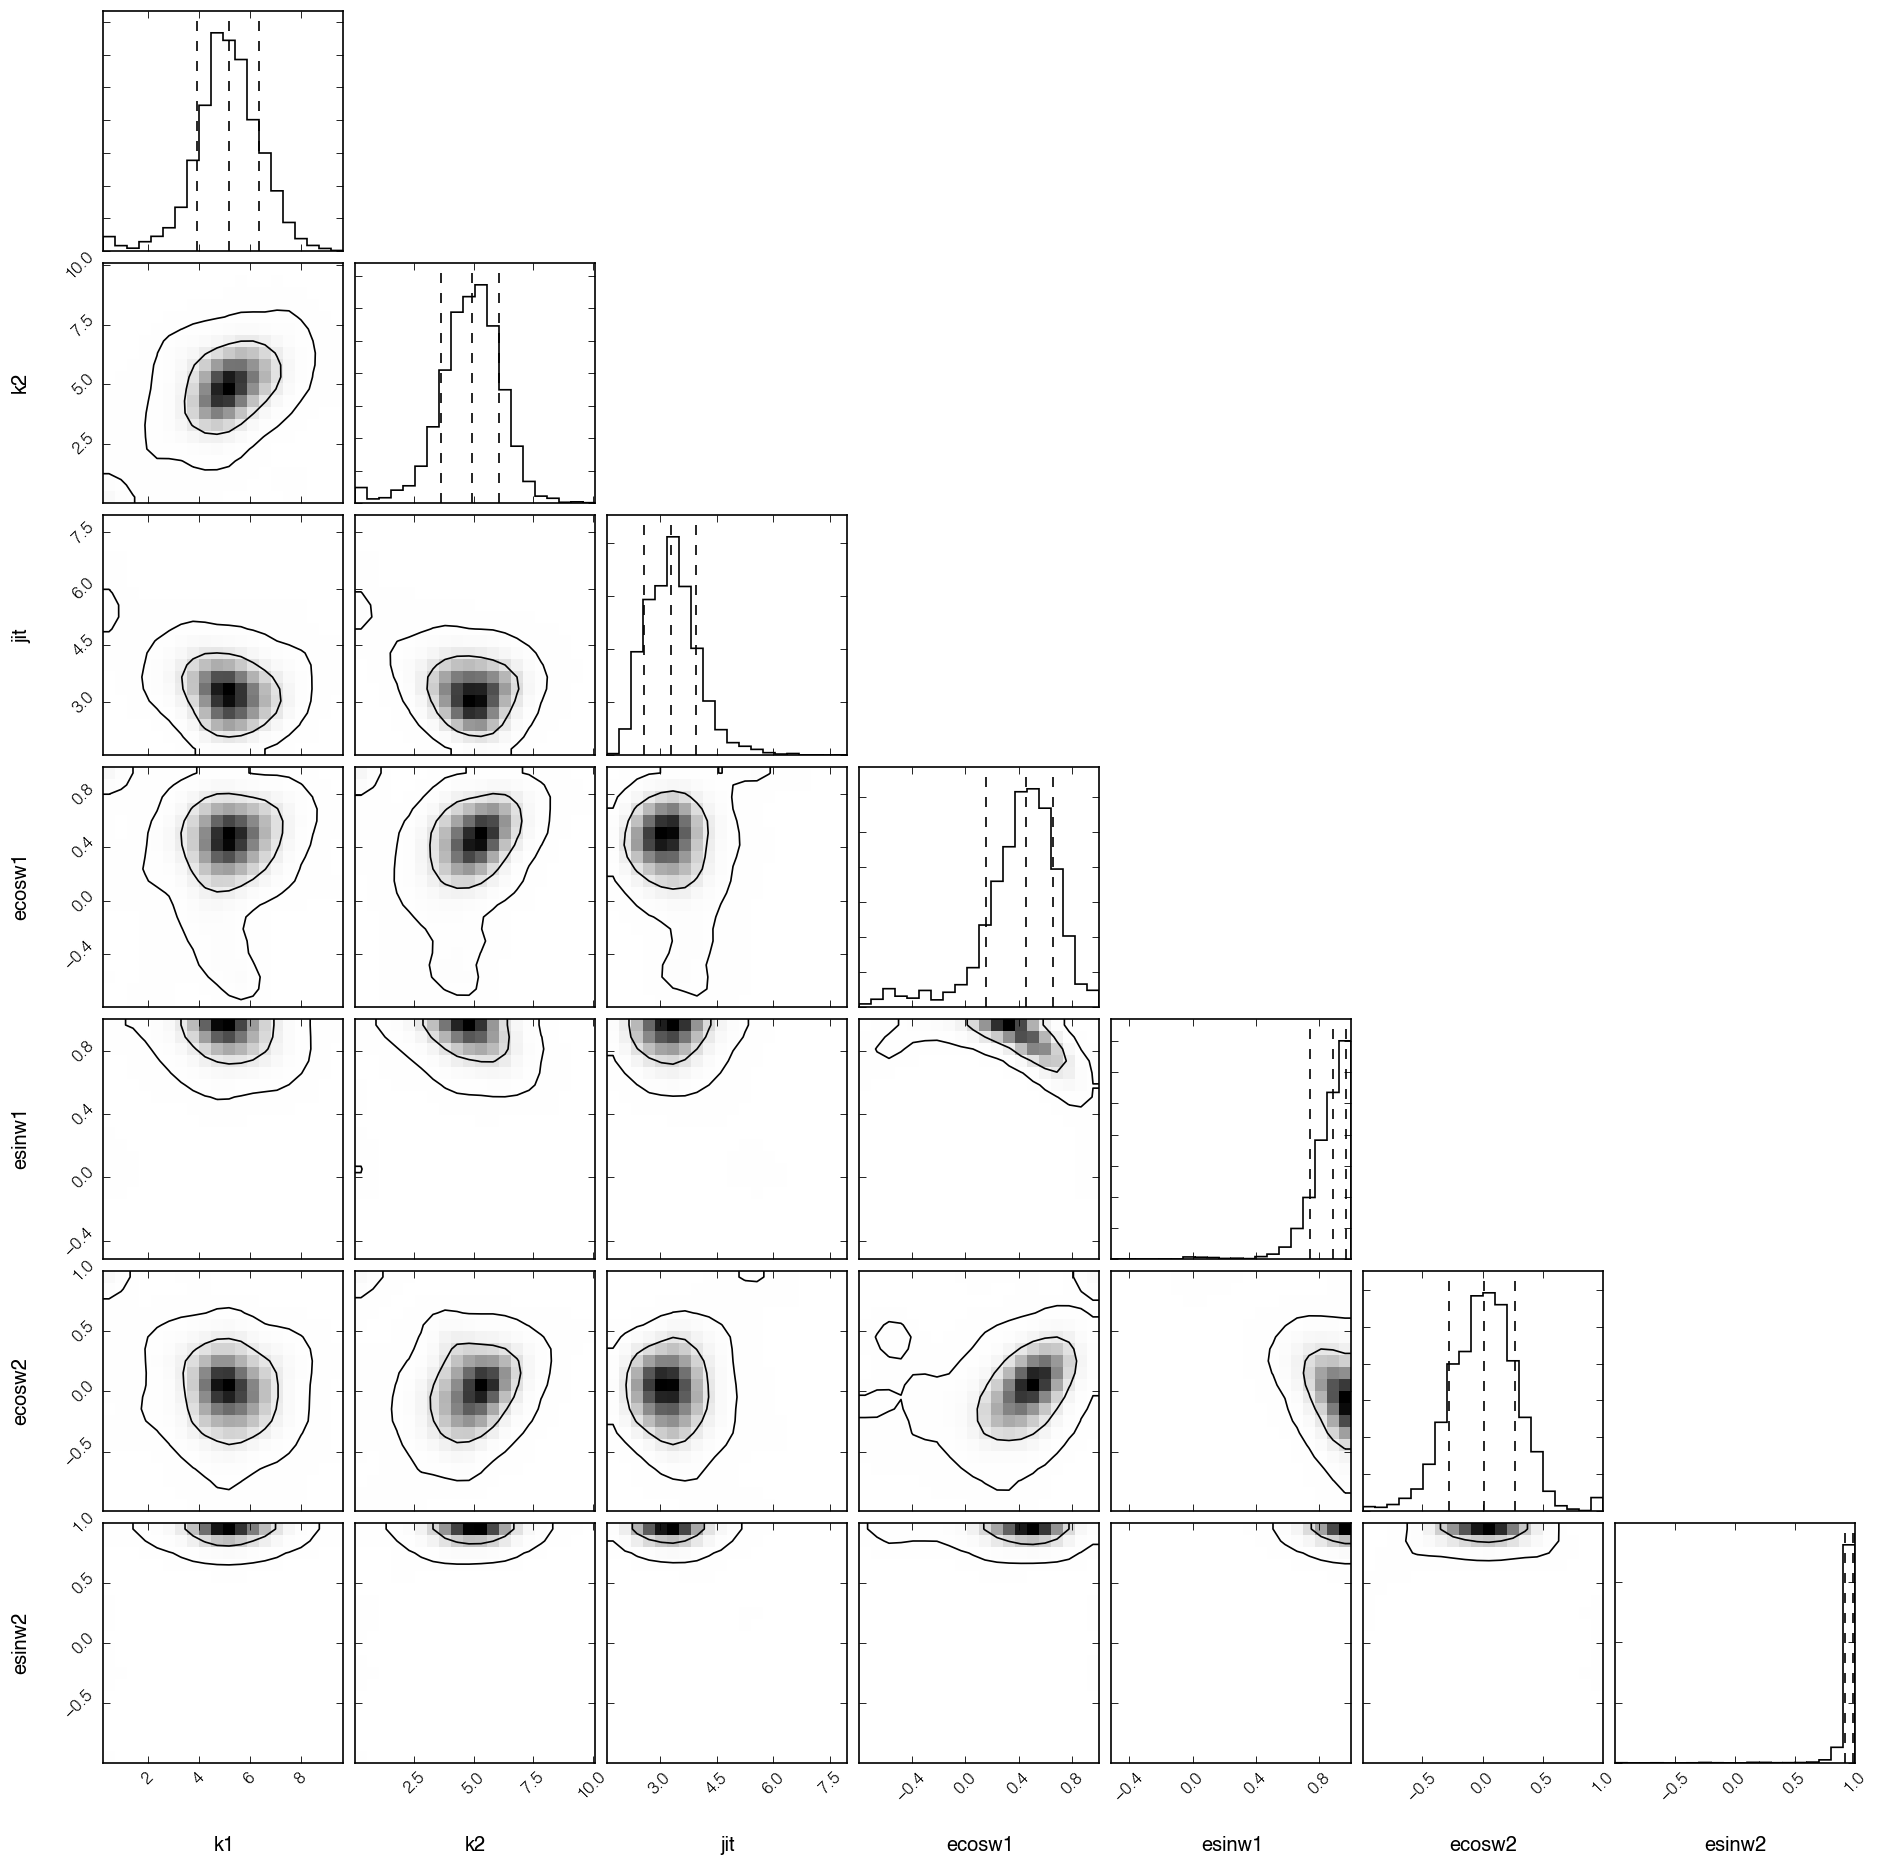

In [30]:
df['k1'] = exp(df['logk1'])
df['k2'] = exp(df['logk2'])
df['jit'] = exp(df['logjit'])
df['e1'] = df['secosw1']**2 + df['sesinw1']**2
df['e2'] = df['secosw2']**2 + df['sesinw2']**2

df['ecosw1'] = df['secosw1']/np.sqrt(df['e1'])
df['esinw1'] = df['sesinw1']/np.sqrt(df['e1'])

df['ecosw2'] = df['secosw2']/np.sqrt(df['e2'])
df['esinw2'] = df['sesinw2']/np.sqrt(df['e2'])


labels = 'k1 k2 jit ecosw1 esinw1 ecosw2 esinw2'.split()
fig = corner.corner(
    df[labels],labels=labels,levels=[0.68,0.95],plot_datapoints=False,smooth=True,bins=20,quantiles=[.14,.5,.84]
    )